# Setup and Data Loading

In [77]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
load_dotenv(os.path.join(project_root, '.env.cred'))

DB_CONFIG = {
    'host': os.getenv('DB_HOST'), 'port': os.getenv('DB_PORT', '3306'),
    'user': os.getenv('DB_USER'), 'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME')
}
# Create the connection engine
connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

def run_query(query, params=None):
    return pd.read_sql(query, engine, params=params)

In [ ]:
# Fetch data
sql_enhanced = """
SELECT 
    a.month_year as month,
    a.total_attendance,
    a.total_first_time_visitors,
    a.total_unique_patrons,
    (a.total_first_time_visitors / a.total_attendance) as first_time_ratio,
    (a.total_unique_patrons / a.total_attendance) as patron_retention,
    COUNT(e.event_id) as event_count,
    SUM(CASE WHEN DAYOFWEEK(e.date) IN (1, 7) THEN 1 ELSE 0 END) as weekend_events,
    
    MONTH(a.month_year) as month_num,
    QUARTER(a.month_year) as season
    
FROM attendance a
LEFT JOIN events e 
    ON DATE_FORMAT(e.date, '%%Y-%%m-01') = a.month_year
GROUP BY a.month_year, a.total_attendance, a.total_first_time_visitors, a.total_unique_patrons
ORDER BY a.month_year ASC
"""
df = run_query(sql_enhanced)
df['attendance_lag1'] = df['total_attendance'].shift(1)

df = df.dropna()

# Attendance Forecast

Mean Absolute Error: ±343 attendees
rmse: 415
R² score: 0.756
 Cross-Validation MAE: ±735 (±346)


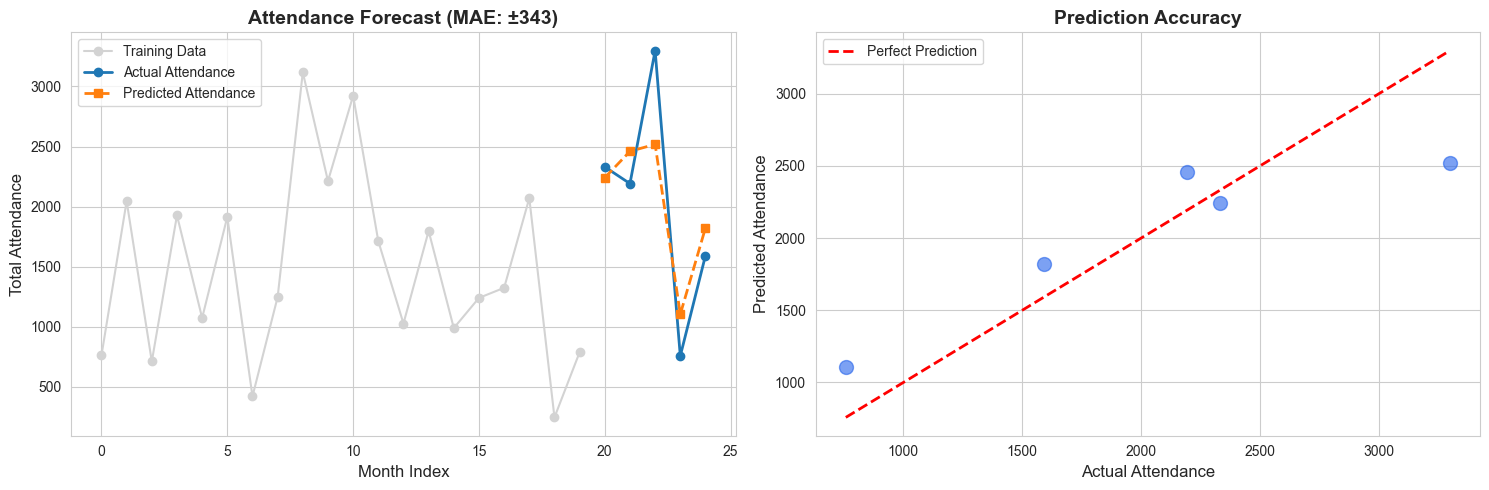

In [72]:
# Define features and target
X = df[['event_count', 'weekend_events', 'first_time_ratio', 'patron_retention', 'season', 'attendance_lag1']]
y = df['total_attendance']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Train Random Forest model
rf_attendance = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_attendance.fit(X_train, y_train)

# Make predictions
y_pred = rf_attendance.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: ±{mae:.0f} attendees")
print(f"rmse: {rmse:.0f}")
print(f"R² score: {r2:.3f}")

cv_scores = cross_val_score(rf_attendance, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f" Cross-Validation MAE: ±{-cv_scores.mean():.0f} (±{cv_scores.std():.0f})")

# Visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Time series comparison
test_months = df.iloc[len(y_train):]['month'].values
ax1.plot(range(len(y_train)), y_train, 'o-', color='lightgray', label='Training Data')
ax1.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, 'o-', linewidth=2, label='Actual Attendance')
ax1.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, 's--', linewidth=2, label='Predicted Attendance')
ax1.set_xlabel('Month Index', fontsize=12)
ax1.set_ylabel('Total Attendance', fontsize=12)
ax1.set_title(f'Attendance Forecast (MAE: ±{mae:.0f})', fontsize=14, fontweight='bold')
ax1.legend()

# Right plot: Prediction accuracy scatter
ax2.scatter(y_test, y_pred, alpha=0.6, s=100, color='#2563eb')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Attendance', fontsize=12)
ax2.set_ylabel('Predicted Attendance', fontsize=12)
ax2.set_title('Prediction Accuracy', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()


# Strongest PRedictions of high attendance

season                   : 40.3% importance
event_count              : 16.3% importance
first_time_ratio         : 15.3% importance
attendance_lag1          : 12.6% importance
weekend_events           : 7.9% importance
patron_retention         : 7.6% importance


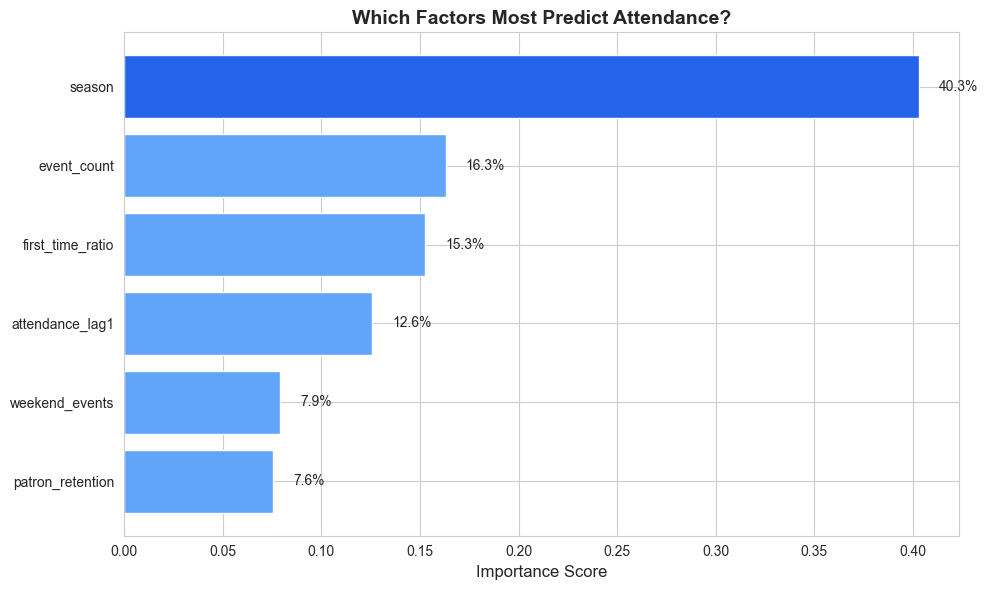

In [73]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_attendance.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:25s}: {row['importance']:.1%} importance")

# Visualize feature importance
plt.figure(figsize=(10, 6))
colors = ['#2563eb' if i == 0 else '#60a5fa' for i in range(len(feature_importance))]
plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Which Factors Most Predict Attendance?', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(feature_importance['importance']):
    plt.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# Revenue 

✓ Revenue dataset: 25 months with donation data
✓ Clean dataset: 24 months (after removing NaN)
✓ Training on 19 months, testing on 5 months

Model Performance:
  MAE: ±$22,316
  RMSE: $26,764
  R² Score: -0.324 (Weak fit - donations are difficult to predict)
  → Donations likely driven by factors not in dataset

💰 Revenue Metrics:
  Average revenue per attendee: $36.10
  Median revenue per attendee: $27.64
  Total donations: $1,407,118


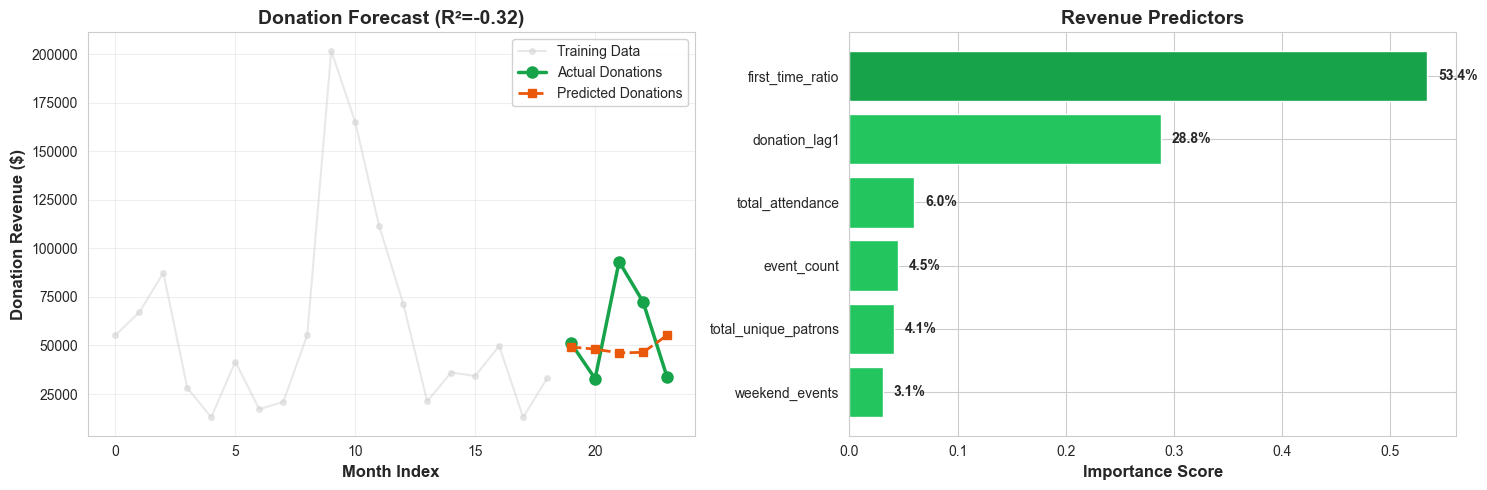

In [ ]:

sql_donations = """
SELECT 
    DATE_FORMAT(d.date, '%%Y-%%m-01') as month,
    SUM(d.donation_received) as total_donations,
    COUNT(*) as donation_count,
    AVG(d.donation_received) as avg_donation,
    MAX(d.donation_received) as max_donation
FROM donations d
GROUP BY DATE_FORMAT(d.date, '%%Y-%%m-01')
ORDER BY month
"""

df_donations = run_query(sql_donations)

# Convert both to datetime for proper merging
df['month'] = pd.to_datetime(df['month'])
df_donations['month'] = pd.to_datetime(df_donations['month'])

# Merge with attendance data
df_revenue = df.merge(df_donations, on='month', how='inner')

print(f"✓ Revenue dataset: {len(df_revenue)} months with donation data")

if len(df_revenue) == 0:
    print("\n❌ ERROR: No matching data found!")
    print("\nDebugging info:")
    print("Attendance date range:", df['month'].min(), "to", df['month'].max())
    print("Donations date range:", df_donations['month'].min(), "to", df_donations['month'].max())
else:
    # Add more predictive features
    df_revenue['revenue_per_attendee'] = df_revenue['total_donations'] / df_revenue['total_attendance']
    df_revenue['donation_lag1'] = df_revenue['total_donations'].shift(1)

    # Drop rows with NaN from lag
    df_revenue_clean = df_revenue.dropna()

    print(f"✓ Clean dataset: {len(df_revenue_clean)} months (after removing NaN)")

    # Prepare ENHANCED revenue model features
    X_revenue = df_revenue_clean[[
        'total_attendance', 
        'first_time_ratio', 
        'total_unique_patrons',
        'event_count',
        'weekend_events',
        'donation_lag1'
    ]]
    y_revenue = df_revenue_clean['total_donations']

    # Split data (time-series aware)
    split_idx = int(len(X_revenue) * 0.8)
    X_rev_train = X_revenue.iloc[:split_idx]
    X_rev_test = X_revenue.iloc[split_idx:]
    y_rev_train = y_revenue.iloc[:split_idx]
    y_rev_test = y_revenue.iloc[split_idx:]

    print(f"✓ Training on {len(X_rev_train)} months, testing on {len(X_rev_test)} months")

    # Train revenue model
    rf_revenue = RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_split=3,
        random_state=42,
        n_jobs=-1
    )
    rf_revenue.fit(X_rev_train, y_rev_train)

    # Predictions
    y_rev_pred = rf_revenue.predict(X_rev_test)

    # Evaluate
    mae_rev = mean_absolute_error(y_rev_test, y_rev_pred)
    r2_rev = r2_score(y_rev_test, y_rev_pred)
    rmse_rev = np.sqrt(mean_squared_error(y_rev_test, y_rev_pred))

    print(f"\nModel Performance:")
    print(f"MAE: ${mae_rev:,.0f}")
    print(f"MSE: ${rmse_rev:,.0f}")
    print(f"r squared score: {r2_rev:.3f}", end="")


    # Calculate revenue per attendee statistics
    avg_revenue_per_attendee = df_revenue_clean['total_donations'].sum() / df_revenue_clean['total_attendance'].sum()
    median_revenue_per_attendee = df_revenue_clean['revenue_per_attendee'].median()

    print(f"\nRevenue Metrics:")
    print(f"Average revenue per attendee: ${avg_revenue_per_attendee:.2f}")
    print(f"Median revenue per attendee: ${median_revenue_per_attendee:.2f}")
    print(f"Total donations: ${df_revenue_clean['total_donations'].sum():,.0f}")

    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Revenue over time
    train_range = range(len(y_rev_train))
    test_range = range(len(y_rev_train), len(y_rev_train) + len(y_rev_test))

    ax1.plot(train_range, y_rev_train, 'o-', 
             color='lightgray', label='Training Data', alpha=0.5, markersize=4)
    ax1.plot(test_range, y_rev_test, 'o-', color='#16a34a', 
             linewidth=2.5, label='Actual Donations', markersize=8)
    ax1.plot(test_range, y_rev_pred, 's--', color='#ea580c', 
             linewidth=2, label='Predicted Donations', markersize=6)
    ax1.set_xlabel('Month Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Donation Revenue ($)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Donation Forecast (R²={r2_rev:.2f})', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3)

    # Feature importance
    rev_importance = pd.DataFrame({
        'feature': X_revenue.columns,
        'importance': rf_revenue.feature_importances_
    }).sort_values('importance', ascending=False)

    colors = ['#16a34a' if i == 0 else '#22c55e' for i in range(len(rev_importance))]
    ax2.barh(rev_importance['feature'], rev_importance['importance'], color=colors)
    ax2.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax2.set_title('Revenue Predictors', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    for i, v in enumerate(rev_importance['importance']):
        ax2.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Future Forecasting

Using last month's metrics as baseline:
  Last month attendance: 1,593
  Last month donations: $33,775

Next Month Attendance Forecasts:
Optimistic (18 events, 10 weekends, 45% new visitors):  1,602 attendees
Baseline (15 events, 8 weekends, 40% new visitors):     1,658 attendees
 Conservative (12 events, 6 weekends, 35% new visitors): 1,639 attendees

Expected Donation Revenue (using historical avg of $36.10/attendee):
 optimistic: $57,845
Baseline:  $59,858
Conservative: $59,166

Confidence Intervals (based on MAE ±343):
Optimistic: 1,259 to 1,945 attendees
Baseline: 1,315 to 2,001 attendees
Conservative: 1,296 to 1,982 attendees


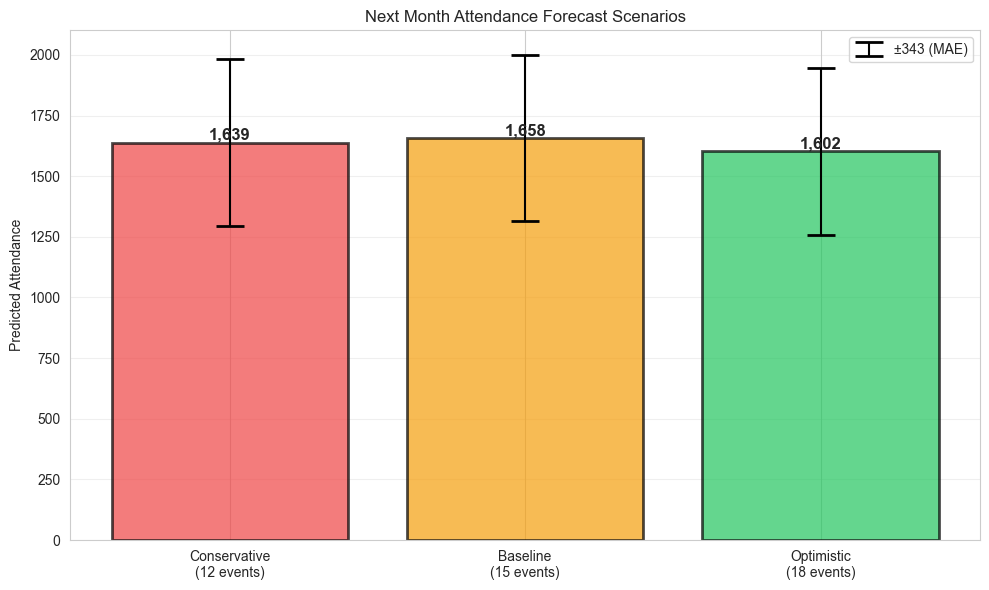

In [ ]:
# Get the most recent month's attendance for lag feature
last_attendance = df['total_attendance'].iloc[-1]
last_donations = df_revenue_clean['total_donations'].iloc[-1] if len(df_revenue_clean) > 0 else 50000

print(f"Using last month's metrics as baseline:")
print(f"  Last month attendance: {last_attendance:,.0f}")
print(f"  Last month donations: ${last_donations:,.0f}\n")

# Scenario 1: Optimistic (high activity)
scenario_high = pd.DataFrame({'event_count': [18],'weekend_events': [10],'first_time_ratio': [0.45],'patron_retention': [0.65],'season': [2], 'attendance_lag1': [last_attendance]})

# Scenario 2: Conservative (lower activity)
scenario_low = pd.DataFrame({'event_count': [12],'weekend_events': [6],'first_time_ratio': [0.35],'patron_retention': [0.60],'season': [3], 'attendance_lag1': [last_attendance]})

# Scenario 3: Baseline (current trends)
scenario_baseline = pd.DataFrame({'event_count': [15],'weekend_events': [8],'first_time_ratio': [0.40],'patron_retention': [0.62],'season': [1], 'attendance_lag1': [last_attendance]})

# Predict attendance for each scenario
pred_high = rf_attendance.predict(scenario_high)[0]
pred_low = rf_attendance.predict(scenario_low)[0]
pred_baseline = rf_attendance.predict(scenario_baseline)[0]

print("Next Month Attendance Forecasts:")
print(f"Optimistic (18 events, 10 weekends, 45% new visitors):  {pred_high:,.0f} attendees")
print(f"Baseline (15 events, 8 weekends, 40% new visitors):     {pred_baseline:,.0f} attendees")
print(f" Conservative (12 events, 6 weekends, 35% new visitors): {pred_low:,.0f} attendees")

# Estimate donation revenue (using simple average, not the model)
# Because the donation model has low r squared and produces unrealistic predictions
avg_revenue_per_attendee = df_revenue_clean['total_donations'].sum() / df_revenue_clean['total_attendance'].sum()

revenue_high = pred_high * avg_revenue_per_attendee
revenue_baseline = pred_baseline * avg_revenue_per_attendee
revenue_low = pred_low * avg_revenue_per_attendee

print("\nExpected Donation Revenue (using historical avg of ${:.2f}/attendee):".format(avg_revenue_per_attendee))
print(f" optimistic: ${revenue_high:,.0f}")
print(f"Baseline:  ${revenue_baseline:,.0f}")
print(f"Conservative: ${revenue_low:,.0f}")

# Show uncertainty ranges
print(f"\nConfidence Intervals")
print(f"Optimistic: {pred_high-mae:,.0f} to {pred_high+mae:,.0f} attendees")
print(f"Baseline: {pred_baseline-mae:,.0f} to {pred_baseline+mae:,.0f} attendees")
print(f"Conservative: {pred_low-mae:,.0f} to {pred_low+mae:,.0f} attendees")

# Visualize scenarios
fig, ax = plt.subplots(figsize=(10, 6))

scenarios = ['Conservative\n(12 events)', 'Baseline\n(15 events)', 'Optimistic\n(18 events)']
predictions = [pred_low, pred_baseline, pred_high]
colors = ['#ef4444', '#f59e0b', '#22c55e']

bars = ax.bar(scenarios, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add error bars
ax.errorbar(scenarios, predictions, yerr=mae, fmt='none', color='black', capsize=10, capthick=2, label=f'±{mae:.0f} (MAE)')

# Add value labels on bars
for bar, pred in zip(bars, predictions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,f'{pred:,.0f}',ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Predicted Attendance')
ax.set_title('Next Month Attendance Forecast Scenarios')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Strategic Recommendations

In [75]:

top_3_features = feature_importance.head(3)
for i, (idx, row) in enumerate(top_3_features.iterrows(), 1):
    feature_name = row['feature']
    importance = row['importance']
    
    if 'first_time' in feature_name:
        print(f"{i}. MAXIMIZE NEW VISITOR ACQUISITION ({importance:.1%} importance)")
        print(f"   → Target marketing campaigns to maintain >40% first-time visitor ratio")
        print(f"   → High first-time ratios correlate with {importance:.0%} of attendance variance\n")
    
    elif 'weekend' in feature_name:
        print(f"{i}. OPTIMIZE WEEKEND SCHEDULING ({importance:.1%} importance)")
        print(f"   → Schedule 8-10 weekend events per month (current strongest operational lever)")
        print(f"   → Weekend shows consistently outperform weekday performances\n")
    
    elif 'event_count' in feature_name:
        print(f"{i}. MAINTAIN HIGH EVENT FREQUENCY ({importance:.1%} importance)")
        print(f"   → Target 15+ events per month to maximize attendance potential")
        print(f"   → More events = more touchpoints = higher overall attendance\n")
    
    else:
        print(f"{i}. MONITOR {feature_name.upper()} ({importance:.1%} importance)")
        print(f"   → This factor shows significant predictive power\n")

print(f"REVENUE OPTIMIZATION:")
print(f"Every 100 additional attendees generates ~${avg_revenue_per_attendee * 100:.0f} in donations")
print(f"Focus on volume (attendance) to drive proportional revenue growth")
print(f"First-time visitors show higher donation propensity\n")

1. MONITOR SEASON (40.3% importance)
   → This factor shows significant predictive power

2. MAINTAIN HIGH EVENT FREQUENCY (16.3% importance)
   → Target 15+ events per month to maximize attendance potential
   → More events = more touchpoints = higher overall attendance

3. MAXIMIZE NEW VISITOR ACQUISITION (15.3% importance)
   → Target marketing campaigns to maintain >40% first-time visitor ratio
   → High first-time ratios correlate with 15% of attendance variance

REVENUE OPTIMIZATION:
Every 100 additional attendees generates ~$3610 in donations
Focus on volume (attendance) to drive proportional revenue growth
First-time visitors show higher donation propensity

